# Import library

In [128]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
%matplotlib inline

# A look at the data

In [220]:
df_seattle_listings = pd.read_csv("seattle/listings.csv")
df_seattle_listings.head();
# df_seattle_listings.describe();

In [131]:
df_seattle_reviews = pd.read_csv("seattle/reviews.csv")
df_seattle_reviews.head();

#### Number of rows, columns

In [132]:
num_seattle_calendar_rows = df_seattle_calendar.shape[0]
num_seattle_calendar_cols = df_seattle_calendar.shape[1]

num_seattle_listings_rows = df_seattle_listings.shape[0]
num_seattle_listings_cols = df_seattle_listings.shape[1]

num_seattle_reviews_rows = df_seattle_reviews.shape[0]
num_seattle_reviews_cols = df_seattle_reviews.shape[1]

print("The seattle calendar database contains {} rows and {} columns." .format(num_seattle_calendar_rows, num_seattle_calendar_cols))
print("The seattle listings database contains {} rows and {} columns." .format(num_seattle_listings_rows, num_seattle_listings_cols))
print("The seattle calendar database contains {} rows and {} columns." .format(num_seattle_reviews_rows, num_seattle_reviews_cols))

The seattle calendar database contains 1393570 rows and 4 columns.
The seattle listings database contains 3818 rows and 92 columns.
The seattle calendar database contains 84849 rows and 6 columns.


#### Name and proportion of missing values of the columns

In [133]:
set(df_seattle_calendar.columns);

In [217]:
set(df_seattle_listings.columns);

In [215]:
set(df_seattle_reviews.columns);

In [136]:
df_seattle_calendar.head();

In [137]:
df_seattle_listings.head();

In [138]:
df_seattle_reviews.head();

In [139]:
np.sum(df_seattle_calendar.isnull()) / num_seattle_calendar_rows;

In [140]:
np.sum(df_seattle_listings.isnull()) / num_seattle_listings_rows;

In [141]:
np.sum(df_seattle_reviews.isnull()) / num_seattle_reviews_rows;

#### Different values

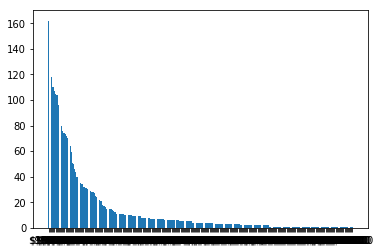

In [142]:
price_vals = df_seattle_listings['price'].value_counts()
plt.bar(price_vals.index, price_vals);

# Question : Is it possible to guess the price of an airbnb

## Variables that determine the price

There is no null values in the column price

In [143]:
sum(df_seattle_listings['price'].isnull())

0

The price has a format which is not a number but a string with the symbol $. We need to transform the price into a float.

In [144]:
df_seattle_listings['price'] = df_seattle_listings['price'].replace('[\$,]', '', regex=True).astype(float)

Correlation of price with other columns

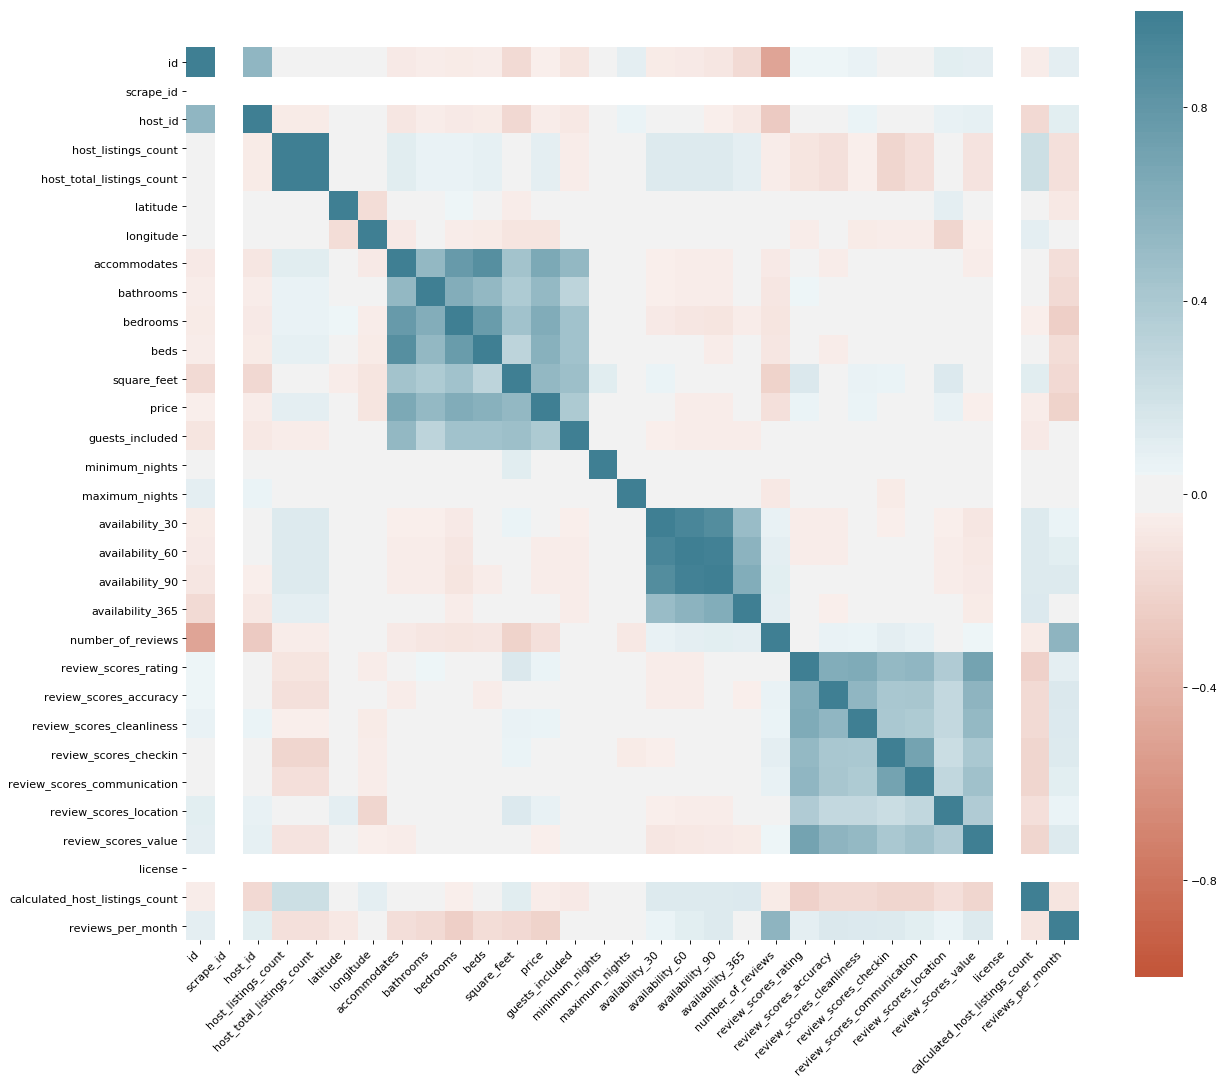

In [145]:
corr = df_seattle_listings.corr()


fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')

ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True);
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

It seems that the price of an airbnb is mainly based on accommodates, bathrooms, bedrooms, beds, square feet, and guest included.

The score reviews has only a negligeable impact on the price so they are neglected in our model.

## Data preparaton for modeling


In [147]:
data = df_seattle_listings[['price', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'square_feet', 'guests_included']]

Let's check what are the number of missing values in each of the columns related to the price

In [148]:
np.sum(data.isnull()) / num_seattle_listings_rows 

price              0.000000
accommodates       0.000000
bathrooms          0.004191
bedrooms           0.001572
beds               0.000262
square_feet        0.974594
guests_included    0.000000
dtype: float64

More than 97 % of the data in square feet columns are missing... Probably too much so that it is a representative parameter in the modeling if we impute this parameters.

In [149]:
data = data.drop(['square_feet'], axis=1)

The other columns can be imputed by the mean of each column.

In [150]:
fill_mean = lambda col: col.fillna(col.mean())

fill_data = data.apply(fill_mean, axis=1)
np.sum(fill_data.isnull())

price              0
accommodates       0
bathrooms          0
bedrooms           0
beds               0
guests_included    0
dtype: int64

In [151]:
# Split into explanatory and response variables
X = fill_data[['accommodates', 'bathrooms', 'bedrooms', 'beds', 'guests_included']]
y = fill_data['price']

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state=42)   

# Predict and score the model
lm_model = LinearRegression(normalize=True)  # Instantiate
lm_model.fit(X_train, y_train)  #Fit

y_test_preds = lm_model.predict(X_test) 
y_train_preds = lm_model.predict(X_train) 

# Rsquared and y_test
rsquared_score = r2_score(y_test, y_test_preds)  # r2_score on test data
rsquared_train_score = r2_score(y_train, y_train_preds) # r2_score on train data
length_y_test = len(y_test)  # num in y_test
length_y_train = len(y_train)  # num in y_train

print("The r-squared score for your model on test data was {} on {} values".format(rsquared_score, length_y_test))
print("The r-squared score for your model on train data was {} on {} values".format(rsquared_train_score, length_y_train))

The r-squared score for your model on test data was 0.4598994075492263 on 1146 values
The r-squared score for your model on train data was 0.43133324413412055 on 2672 values


Approximately half of the observed variation can be explained by the model's inputs

# Question : How airbnb has developped since 2008?

In [152]:
df_seattle_listings = df_seattle_listings.dropna(subset=['host_since', 'host_id'])

In [153]:
data = df_seattle_listings.groupby('host_since')['id'].count()
time = data.index
number_hosts = data.values
time = pd.to_datetime(time).to_pydatetime()
number_hosts = np.cumsum(number_hosts)

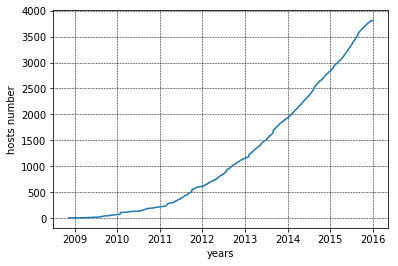

In [154]:
plt.plot(time, number_hosts);
plt.grid(b=True, which='both', color='black',linestyle='--', linewidth = 0.5);
plt.xlabel('years');
plt.ylabel('hosts number');

# Question : AirBNB price and avaibility along the year ?

We load the database corresponding to the transaction since april 2016

In [239]:
df_seattle_calendar = pd.read_csv("seattle/calendar.csv")
df_seattle_calendar.head()

,listing_id,date,available,price
0,241032,2016-01-04,t,$85.00
1,241032,2016-01-05,t,$85.00
2,241032,2016-01-06,f,NaN
3,241032,2016-01-07,f,NaN
4,241032,2016-01-08,f,NaN


### Data preparation

We convert the "date" column into a datetime column

In [240]:
df_seattle_calendar['date'] = pd.to_datetime(df_seattle_calendar['date']);

We replace the string values of "available" column by boolean

In [241]:
d = {'t': True, 'f': False}
df_seattle_calendar['available'] = df_seattle_calendar['available'].map(d);

We check how many null values there is in "price" column

In [242]:
np.sum(df_seattle_calendar['price'].isnull()) / df_seattle_calendar.shape[0]

0.32938998399793334

If we look closer, we notice that the missing values occur when the airbnb is free, so nobody was renting it 1 day over 3 on the average.


In [243]:
df_seattle_calendar.head()

,listing_id,date,available,price
0,241032,2016-01-04,True,$85.00
1,241032,2016-01-05,True,$85.00
2,241032,2016-01-06,False,NaN
3,241032,2016-01-07,False,NaN
4,241032,2016-01-08,False,NaN


We can replace NaN values by 0 without loss of information in the price column

In [244]:
df_seattle_calendar['price'] = df_seattle_calendar['price'].fillna(0);

We replace the string value of the "price" column by float numbers corresponding to the price

In [245]:
df_seattle_calendar['price'] = df_seattle_calendar['price'].replace('[\$,]', '', regex=True).astype(float)

Let´s have a look to our cleaned data

In [246]:
df_seattle_calendar.head()

,listing_id,date,available,price
0,241032,2016-01-04,True,85.0
1,241032,2016-01-05,True,85.0
2,241032,2016-01-06,False,0.0
3,241032,2016-01-07,False,0.0
4,241032,2016-01-08,False,0.0


## What is the number of avaible airbnb during the year?

In [295]:
data = df_seattle_calendar.groupby(df_seattle_calendar['date'].dt.strftime('%m'))['available'].mean()

(0.5, 0.8)

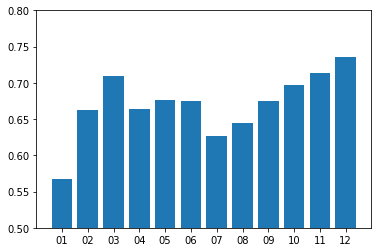

In [296]:
plt.bar(data.index, data.values)
plt.ylim([0.5, 0.8])

## What is price variation during the year?

In [297]:
data_2 = df_seattle_calendar.groupby(df_seattle_calendar['date'].dt.strftime('%m'))['price'].mean()

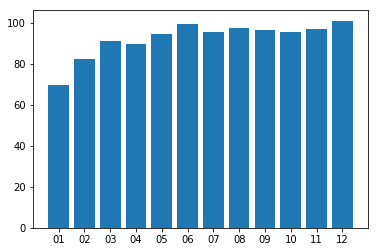

In [298]:
plt.bar(data_2.index, data_2.values);

## Correlation between price and avaibility?

In [309]:
np.corrcoef(data.values, data_2.values)

array([[1.        , 0.71571039],
       [0.71571039, 1.        ]])

# Question : How much AirBNB homes are earning in certain time frames and areas ?

We note that less appartment are available in January.

In [314]:
data_test = df_seattle_calendar;

In [315]:
data_test.groupby(df_seattle_calendar['date'].dt.strftime('%D'))['price'].sum()

date
01/01/17    403607.0
01/02/17    376350.0
01/04/16    211819.0
01/05/16    225312.0
01/06/16    220815.0
01/07/16    214823.0
01/08/16    227456.0
01/09/16    236326.0
01/10/16    241084.0
01/11/16    247497.0
01/12/16    250976.0
01/13/16    248872.0
01/14/16    244997.0
01/15/16    253687.0
01/16/16    251673.0
01/17/16    254291.0
01/18/16    271603.0
01/19/16    271292.0
01/20/16    271667.0
01/21/16    269447.0
01/22/16    282930.0
01/23/16    283974.0
01/24/16    276183.0
01/25/16    277847.0
01/26/16    277390.0
01/27/16    275405.0
01/28/16    267852.0
01/29/16    281596.0
01/30/16    282607.0
01/31/16    282170.0
              ...   
12/02/16    389987.0
12/03/16    388831.0
12/04/16    371099.0
12/05/16    369752.0
12/06/16    369387.0
12/07/16    370047.0
12/08/16    377231.0
12/09/16    395383.0
12/10/16    394549.0
12/11/16    374121.0
12/12/16    372542.0
12/13/16    372917.0
12/14/16    373668.0
12/15/16    377816.0
12/16/16    396068.0
12/17/16    396467.0
12/18/16

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
 <a list of 13 Text xticklabel objects>)

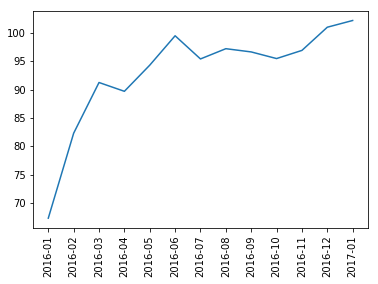

In [317]:
plt.plot(data_test.groupby(df_seattle_calendar['date'].dt.strftime('%Y-%m'))['price'].mean());
plt.xticks(rotation=90)